In [1]:
import matplotlib.pyplot as plt
from matplotlib  import cm
import matplotlib.animation
plt.rcParams.update({'font.size': 8})

%matplotlib ipympl
import numpy as np
import pandas as pd
import random

from scipy.spatial import KDTree, cKDTree
from scipy.ndimage import uniform_filter1d
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

import joblib
import time
from numba_progress import ProgressBar
from tqdm import tqdm
import trackpy as tp
from numba import njit, prange

from yupi import Trajectory
import yupi.graphics as yg
import yupi.stats as ys

from utility import get_imsd, get_imsd_windowed, get_emsd, get_emsd_windowed, fit_hist, MB_2D,\
                    normal_distr, lorentian_distr, get_trajs, speed_windowed, theta_windowed, \
                    get_smooth_trajs, get_velocities

show_verb = False
save_verb = True
anim_show_verb = False

In [2]:
rawTrajs = pd.read_parquet("../tracking/results/tracking_data/trackpy_pre_merge.parquet")

n = max(rawTrajs.particle)
random.seed(5)
colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(n)]
for i in range(max(rawTrajs.particle)+1-n):
    colors.append("#00FFFF")
c = []
for p in rawTrajs.particle:
    c.append(colors[p])
rawTrajs["color"] = c
display(rawTrajs.head())

red_particle_idx = 17
nDrops = len(rawTrajs.loc[rawTrajs.frame==0])
nFrames = max(rawTrajs.frame) + 1
print(f"nDrops:{nDrops}")
print(f"nFrames:{nFrames} --> {nFrames/10:.2f} s")


# WINDOWED ANALYSIS PARAMETERS
window = 3200 # 320 s
stride = 100 # 10 s
print(f"window of {window/10} s, stride of {stride/10} s")
startFrames = np.arange(0, nFrames-window, stride, dtype=int)
endFrames = startFrames + window
nSteps = len(startFrames)
print(f"number of steps: {nSteps}")


# step 10 with a 10 fps video --> 1 s
units = "px/s"
default_kwargs_blue = {"color": "#00FFFF", "ec": (0, 0, 0, 0.6), "density": True}
default_kwargs_red = {"color": "#EE4B2B", "ec": (0, 0, 0, 0.6), "density": True}
    
maxLagtime = 1000
#x = np.arange(0.1, 100.1, 0.1) # without initial point
x = np.arange(0, 100, 0.1) # with initial point

blueTrajs, redTraj = get_trajs(nDrops, red_particle_idx, rawTrajs)

# Trajectory Smoothing: using a Savgol Filter in order to drop the noise due to the tracking procedure
smoothTrajs = get_smooth_trajs(rawTrajs, nDrops, 30, 2)

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,color
0,171.735232,417.068536,6831.555216,10.518919,0.017850,12.622410,70005.0,0.001334,0,0,#8B0E71
1,529.175095,508.570095,7479.073073,10.578953,0.014188,14.155974,74285.0,0.001096,0,1,#53BF7C
2,528.655276,559.415666,7042.243300,10.341892,0.035362,15.689538,72910.0,0.001162,0,2,#3706D8
3,536.996577,765.536854,7202.087843,10.486024,0.053956,14.391907,75383.0,0.001047,0,3,#5C524E
4,555.453979,172.020692,7593.854431,10.570402,0.016828,14.038008,77709.0,0.000958,0,4,#440066


nDrops:50
nFrames:32000 --> 3200.00 s
window of 320.0 s, stride of 10.0 s
number of steps: 288


# NEW UPDATES 

In [ ]:
# select 100 frames from the trajectory of  particle id = 10
test = smoothTrajs.loc[(smoothTrajs.frame.between(0, 30000)) & (smoothTrajs.particle == 10)]

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
scatter = ax.scatter(test.x, test.y, c = np.arange(0, 30001, 1), s = .1, cmap = cm.jet)
ax.set(xlabel="x [px]", ylabel="y [px]", title = "Trajectory of particle id = 10", xlim=(0, 900), ylim=(0, 900))
ax.grid(True, linestyle='-', color = '0.75')
ax.legend(*scatter.legend_elements(), title = "Time", fontsize = 8, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show()

## CHECK BALLISTIC REGIME BETWEEN 0-1 S 

In [3]:
pxDimension = 1 # has to be fixed 
fps = 10 # fps of the video
maxLagtime = 1000 # maximum lagtime to be considered
#x = np.array(imsd[1:].index)
x = np.arange(1., 100.1, .1)
imsd, fit, pw_exp, fit_ball, pw_exp_ball = get_imsd(smoothTrajs, pxDimension, fps, maxLagtime, nDrops)

In [4]:
fit_ball.shape

(50, 10)

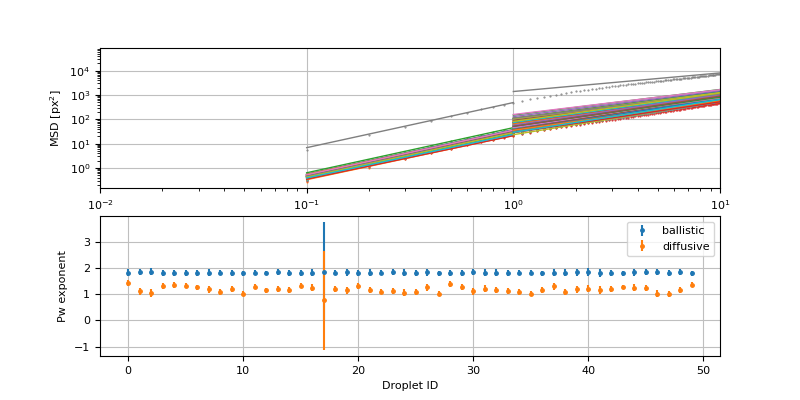

In [5]:
fig, (ax, ax1) = plt.subplots(2, 1, figsize = (8, 4))
ax.plot(imsd.index, imsd, '.',  markersize = 1)
ax.plot(imsd[:1].index, fit_ball.T, linewidth = 1)
ax.plot(imsd[1:].index, fit.T, linewidth = 1)
ax.set(xlabel="lag time [s]", ylabel="MSD [px$^2$]", xscale = "log", yscale = "log", xlim=(0.01, 10))
ax.grid(True, linestyle='-', color = '0.75')
ax1.errorbar(np.arange(0, nDrops, 1), pw_exp_ball[:, 0, 1], yerr = pw_exp_ball[:, 1, 0], fmt = '.', markersize = 5, label = "ballistic")
ax1.errorbar(np.arange(0, nDrops, 1), pw_exp[:, 0, 1], yerr = pw_exp_ball[:, 1, 0], fmt = '.', markersize = 5, label = "diffusive")
ax1.set(xlabel="Droplet ID", ylabel="Pw exponent")
ax1.grid(True, linestyle='-', color = '0.75')
ax1.legend()
plt.show()

In [6]:
MSD_b_smooth, MSD_r_smooth, diffusive_results, ballistic_results = get_emsd(imsd, x, red_particle_idx, nDrops)

In [8]:
ballistic_results.keys()

dict_keys(['fit_b', 'pw_exp_b', 'fit_r', 'pw_exp_r'])

In [ ]:
fit_b_ball, pw_exp_b_ball = powerLawFit(MSD_b[0][:10], np.arange(0.1, 1.1, 0.1), 1, MSD_b[1][:9])
fit_r_ball, pw_exp_r_ball = powerLawFit(MSD_r[:10], np.arange(0.1, 1.1, 0.1), 1, None)

In [ ]:
a = [round(pw_exp_b_ball[0, 1], 3), round(pw_exp_b_ball[1, 1], 3)]
b = [round(pw_exp_r_ball[0, 1], 3), round(pw_exp_r_ball[1, 1], 3)]
print(f"Smooth trajs - Ballistic - Blue Particles: {a[0]} ± {a[1]}, Red Particle: {b[0]} ± {b[1]}")

a = [round(fit["pw_exp_b"][0, 1], 3), round(fit["pw_exp_b"][1, 1], 3)]
b = [round(fit["pw_exp_r"][0, 1], 3), round(fit["pw_exp_r"][1, 1], 3)]
print(f"Smooth trajs - Diffusive - Blue Particles: {a[0]} ± {a[1]}, Red Particle: {b[0]} ± {b[1]}")

fig, ax = plt.subplots(1, 1, figsize = (10, 4))
ax.plot(imsd.index, MSD_b[0], 'b-', label = "Blue particles") 
ax.plot(imsd[1:].index, fit["fit_b"], 'b--')
ax.plot(imsd[:1].index, fit_b_ball, 'b--')
ax.fill_between(imsd.index, MSD_b[0] - MSD_b[1], MSD_b[0] + MSD_b[1], alpha=0.5, edgecolor='#00FFFF', facecolor='#F0FFFF')
ax.plot(imsd.index, MSD_r, 'r-', label = "Red particle")
ax.plot(imsd[1:].index, fit["fit_r"], 'r--')
ax.plot(imsd[:1].index, fit_r_ball, 'r--')
ax.set(xscale = 'log', yscale = 'log', ylabel = r'$\langle \Delta r^2 \rangle$ [$px^2$]',   
        xlabel = 'lag time $t$ [s]', title = "EMSD - Raw Trajectories")
ax.legend()
ax.grid()
plt.show()

# DROPLET SIZE VS THINGS

In [ ]:
# mean and std droplet diameter per frame
mean_d = 2*rawTrajs.groupby("frame").mean()["size"].values
std_d = 2*rawTrajs.groupby("frame").std()["size"].values

# mean and std droplet diameter per frame
mean_d_wind = np.zeros(nSteps)
std_d_wind = np.zeros(nSteps)
for i, start in enumerate(startFrames):
    mean_d_wind[i] = np.mean(mean_d[start:start+window])
    std_d_wind[i] = np.std(mean_d[start:start+window])

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
ax.plot(np.arange(0, nFrames, 1)/10, mean_d)
ax.fill_between(np.arange(0, nFrames, 1)/10, mean_d - std_d, mean_d + std_d, alpha=0.5)
ax.set(xlabel = "Time [s]", ylabel = "d [px]", title = "Droplet diameter over time")
ax.grid(True, linestyle='-', color = '0.75')
plt.show()

fig, ax = plt.subplots(1, 1, figsize = (10, 5))
ax.plot(startFrames/10, mean_d_wind)
ax.fill_between(startFrames/10, mean_d_wind - std_d_wind, mean_d_wind + std_d_wind, alpha=0.5)
ax.set(xlabel = "Window Time [s]", ylabel = "d [px]", title = "Droplet diameter over window time")
ax.grid(True, linestyle='-', color = '0.75')
plt.show()

## vs Velocity Variance

In [ ]:
show_verb = False
run_windowed_analysis = False
overwrite = False
animated_plot_verb = False

print(f"Velocity Autocorrelation Analysis: show_verb = {show_verb}, run_windowed_analysis = {run_windowed_analysis}, animated_plot_verb = {animated_plot_verb}")
%run ./analysis_modules/velocity_autocorrelation.ipynb

In [ ]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize = (10, 5), sharex = True, sharey = True)
scatter = ax.scatter(vacf_b_wind["0"], mean_d_wind, s = 10, c = startFrames/10, marker = 'o', cmap = cm.Blues)
scatter1 = ax.scatter(vacf_r_wind["0"], mean_d_wind, s = 10, c = startFrames/10, marker = 'o', cmap = cm.Reds)
ax.set(title = "Raw Trajs", xlabel = r"$\sigma_v^2$", ylabel = "d [px]" )
ax.grid(True, linestyle='-', color = '0.75')

scatter2 = ax1.scatter(vacf_b_wind_smooth["0"], mean_d_wind, s = 10, c = startFrames/10, marker = 'o', cmap = cm.Blues)
scatter3 = ax1.scatter(vacf_r_wind_smooth["0"], mean_d_wind, s = 10, c = startFrames/10, marker = 'o', cmap = cm.Reds)
ax1.set(title = "Smooth Trajs", xlabel = r"$\sigma_v^2$", ylabel = "d [px]")
ax1.grid(True, linestyle='-', color = '0.75')

fig.suptitle("Velocity Variance vs. Mean Distance")
fig.legend(*scatter3.legend_elements(), title = "Window Time", fontsize = 8, loc = 7)
fig.tight_layout()
fig.subplots_adjust(right=1)
if save_verb: plt.savefig('./results/distance_scatterplots/v_variance.png', bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

## vs Effective Temperature from velocity distribution

In [ ]:
show_verb = False
animated_plot_verb = False
print(f"Speed and Turning Angles Analysis: show_verb = {show_verb}, animated_plot_verb = {animated_plot_verb}")
%run ./analysis_modules/speed_and_turning_angles.ipynb

In [ ]:
eff_T_speed_b = blue_fit_wind[:, 0]
eff_T_speed_b_sigma = blue_fit_wind[:, 1]
eff_T_speed_r = red_fit_wind[:, 0]
eff_T_speed_r_sigma = red_fit_wind[:, 1]

eff_T_speed_b_smooth = blue_fit_wind_smooth[:, 0]
eff_T_speed_b_sigma_smooth = blue_fit_wind_smooth[:, 1]
eff_T_speed_r_smooth = red_fit_wind_smooth[:, 0]
eff_T_speed_r_sigma_smooth = red_fit_wind_smooth[:, 1]

In [ ]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize = (10, 5), sharex = True, sharey = True)
scatter = ax.scatter(eff_T_speed_b, mean_d_wind, s = 20, c = startFrames/10, marker = 'o', cmap = cm.Blues)
scatter1 = ax.scatter(eff_T_speed_r, mean_d_wind, s = 20, c = startFrames/10, marker = 'o', cmap = cm.Reds)
ax.set(title = "Raw Trajs", xlabel = r"$T_{eff} \; [??]$", ylabel = "d [px]")
ax.grid(True, linestyle='-', color = '0.75')

scatter2 = ax1.scatter(eff_T_speed_b_smooth, mean_d_wind, s = 20, c = startFrames/10, marker = 'o', cmap = cm.Blues)
scatter3 = ax1.scatter(eff_T_speed_r_smooth, mean_d_wind, s = 20, c = startFrames/10, marker = 'o', cmap = cm.Reds)
ax1.set(title = "Smooth Trajs", xlabel = r"$T_{eff} \; [??]$", ylabel = "d [px]")
ax1.grid(True, linestyle='-', color = '0.75')

fig.suptitle("Effective Temperature vs. Mean Distance")
fig.legend(*scatter3.legend_elements(), title = "Window Time", fontsize = 8, loc=7)
fig.tight_layout()
fig.subplots_adjust(right=1)
plt.tight_layout()
if save_verb: plt.savefig('./results/distance_scatterplots/eff_T.png', bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

## vs Power law exponent from msd 

In [ ]:
show_verb = False
run_windowed_analysis = False
animated_plot_verb = False
print(f"MSD Analysis: show_verb = {show_verb}, run_windowed_analysis = {run_windowed_analysis}, animated_plot_verb = {animated_plot_verb}")

%run ./analysis_modules/msd.ipynb

In [ ]:
pw_b = fit_dict["pw_exp_wind_b"][:, 0, 1]
pw_b_std = fit_dict["pw_exp_wind_b"][:, 1, 1]
pw_r = fit_dict["pw_exp_wind_r"][:, 0, 1]
pw_r_std = fit_dict["pw_exp_wind_r"][:, 1, 1]

pw_b_smooth = fit_dict_smooth["pw_exp_wind_b"][:, 0, 1]
pw_b_std_smooth = fit_dict_smooth["pw_exp_wind_b"][:, 1, 1]
pw_r_smooth = fit_dict_smooth["pw_exp_wind_r"][:, 0, 1]
pw_r_std_smooth = fit_dict_smooth["pw_exp_wind_r"][:, 1, 1]

In [ ]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize = (10, 5), sharex = True, sharey = True)
scatter = ax.scatter(pw_b, mean_d_wind, s = 20, c = startFrames/10, marker = 'o', cmap = cm.Blues)
scatter1 = ax.scatter(pw_r, mean_d_wind, s = 20, c = startFrames/10, marker = 'o', cmap = cm.Reds)
ax.set(title = "Raw Trajs", xlabel =  "pw exponent", ylabel = "d [px]")
ax.grid(True, linestyle='-', color = '0.75')

scatter2 = ax1.scatter(pw_b_smooth, mean_d_wind, s = 20, c = startFrames/10, marker = 'o', cmap = cm.Blues)
scatter3 = ax1.scatter(pw_r_smooth, mean_d_wind, s = 20, c = startFrames/10, marker = 'o', cmap = cm.Reds)
ax1.set(title = "Smooth Trajs", xlabel = "pw exponent", ylabel = "d [px]")
ax1.grid(True, linestyle='-', color = '0.75')

fig.suptitle("Power Law Exponent vs. Mean Distance")
fig.legend(*scatter3.legend_elements(), title = "Window Time", fontsize = 8, loc=7)
fig.tight_layout()
fig.subplots_adjust(right=1)
plt.tight_layout()
if save_verb: plt.savefig('./results/distance_scatterplots/pw_law.png', bbox_inches='tight')
if show_verb:
    plt.show()
else:
    plt.close()

# 3 body

In [ ]:
@njit(fastmath=True)
def b_weight(x, mu, sigma):
    return np.exp(-0.5*((x-mu)/sigma)**2)

@njit(fastmath=True)
def angle_between(v1, v2):
    return np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))

@njit(parallel = True, fastmath=True)
def three_body_frame(coords, b, sigma):
    temp = np.zeros(( nDrops, (nDrops-1)*(nDrops-2) ))
    temp1 = np.zeros(( nDrops, (nDrops-1)*(nDrops-2) ))
    for i in prange(nDrops):
        count = 0
        r_i = coords[i]
        for j in range(nDrops):
            if i != j:
                r_ij = coords[j] - r_i
                for k in range(nDrops):
                    if k != i and k != j:
                        r_ik = coords[k] - r_i
                        temp[i, count] = angle_between(r_ij, r_ik)
                        temp1[i, count] = b_weight(np.linalg.norm(r_ij), b, sigma) * b_weight(np.linalg.norm(r_ik), b, sigma)
                        count += 1 
    return temp, temp1 

In [ ]:
coords = COORDS[0*nDrops:(0+1)*nDrops,:]
print(coords[:3])
i = 0
# coords without index i, without using delete
indx = np.ones(nDrops, dtype=int)
indx[i] = 0
coords1 = coords[indx]
print(coords1[:3])

In [ ]:
COORDS = np.array(rawTrajs.loc[:,["x","y"]])
bList = [i/10 for i in range(1, 10, 1)]
sigma = 10
H = np.zeros((len(bList), nDrops, (nDrops-1)*(nDrops-2) ))
ang = np.zeros((len(bList), nDrops, (nDrops-1)*(nDrops-2) ))

for b_ind, b in tqdm(enumerate(bList)):
    ang[b_ind], H[b_ind] = three_body_frame(COORDS[0*nDrops:(0+1)*nDrops,:], b, sigma)

In [ ]:
hist_bins = np.linspace(0, np.pi, 10)
counts = np.zeros((len(bList), nDrops, len(hist_bins)-1))
bins = np.zeros((len(bList), nDrops, len(hist_bins)))
for b_ind in range(len(bList)):
    for i in range(nDrops):
        counts[b_ind, i], bins[b_ind, i] = np.histogram(ang[b_ind, i], bins=hist_bins, weights=H[b_ind, i])

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(6, 6), sharex=True, sharey=True)
ax[0, 0].stairs(counts[0, 0], bins[0, 0], fill=True)
ax[1, 0].stairs(counts[2, 0], bins[2, 0], fill=True)
ax[0, 1].stairs(counts[5, 0], bins[5, 0], fill=True)
ax[1, 1].stairs(counts[-1, 0], bins[-1, 0], fill=True)
plt.tight_layout()
plt.show()

# CUMULATIVE TURNING ANGLES

In [ ]:
blueTrajs_smooth, redTraj_smooth = get_trajs(nDrops, red_particle_idx, smoothTrajs)

theta_blue_smooth = ys.turning_angles_ensemble(blueTrajs_smooth, centered = True, accumulate = True)
theta_red_smooth = ys.turning_angles_ensemble(redTraj_smooth, centered = True, accumulate = True)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharex=True, sharey=True)
ax.plot(np.arange(0, 31999), theta_red_smooth)
ax.set(title = "Turning Angles", xlabel = "Time", ylabel = "Turning Angle")
ax.grid(True, linestyle='-', color = '0.75')
plt.show()

# MEAN SQUARED ANGULAR DIFFERENCE

In [9]:
def get_msad(maxLagtime, r):
    current_msd = np.empty(maxLagtime)
    for lag_ in prange(1, maxLagtime + 1):
        x_ = np.sum(r[lag_:] * r[:-lag_], axis=1) / (np.linalg.norm(r[lag_:], axis=1)*np.linalg.norm(r[:-lag_], axis=1))
        temp = np.arccos( np.clip(x_, -1, 1) )
        current_msd[lag_ - 1] = np.mean(temp)
    return current_msd

In [10]:
# mean squared angular displacement 
blueTrajs, redTraj = get_trajs(nDrops, red_particle_idx, rawTrajs)
maxLagtime = 1000
msad = np.empty((len(blueTrajs), maxLagtime))
for i in tqdm(range(len(blueTrajs))):
    r = np.array(blueTrajs[i].r)
    current_msd = get_msad(maxLagtime, r)
    msad[i] = current_msd
msad_b = np.mean(msad, axis=0)
msad_b_std = np.std(msad, axis=0)

msad_r = get_msad(maxLagtime, np.array(redTraj[0].r))

100%|██████████| 49/49 [01:24<00:00,  1.72s/it]


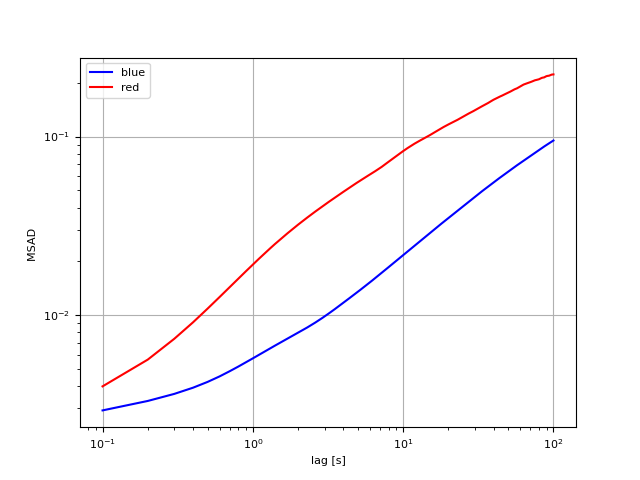

In [11]:
fig, ax = plt.subplots()
ax.plot(np.arange(1, maxLagtime+1, 1)/10, msad_b, 'b', label="blue")
ax.plot(np.arange(1, maxLagtime+1, 1)/10, msad_r, 'r', label="red")
ax.legend()
ax.grid()
ax.set(xlabel="lag [s]", ylabel="MSAD ", xscale="log", yscale="log")
plt.show()

# VELOCITY CORRELATION

In [ ]:
@njit(parallel=True, fastmath=True)
def get_corr(velocities, maxLagtime_):
    xx = np.zeros((velocities.shape[0], maxLagtime_))
    yy = np.zeros((velocities.shape[0], maxLagtime_))
    xy = np.zeros((velocities.shape[0], maxLagtime_))
    for i in prange(velocities.shape[0]):
        v = velocities[i]
        xx[i, 0] = np.corrcoef(v[0], v[0])[0, 1]
        yy[i, 0] = np.corrcoef(v[1], v[1])[0, 1]
        xy[i, 0] = np.corrcoef(v[0], v[1])[0, 1]
        
        for lag_ in prange(1, maxLagtime_):
            xx[i, lag_] = np.corrcoef(v[0, :-lag_], v[0, lag_:])[0, 1]
            yy[i, lag_] = np.corrcoef(v[1, :-lag_], v[1, lag_:])[0, 1]
            xy[i, lag_] = np.corrcoef(v[0, :-lag_], v[1, lag_:])[0, 1]
    return xx, yy, xy

def corr_windowed(nSteps, maxLagtime, startFrames, endFrames, trajectories, red_particle_idx, nDrops):
    corr_b = np.zeros((nSteps, 3, maxLagtime))
    corr_std_b = np.zeros((nSteps, 3, maxLagtime))
    corr_r = np.zeros((nSteps, 3, maxLagtime))
    corr_std_r = np.zeros((nSteps, 3, maxLagtime))

    for k in tqdm(range(nSteps)):
        trajs = trajectories.loc[trajectories.frame.between(startFrames[k], endFrames[k])]
        blueTrajs, redTraj = get_trajs(nDrops, red_particle_idx, trajs)

        res = np.array(get_corr(get_velocities(blueTrajs), maxLagtime))
        corr_b[k], corr_std_b[k] = res.mean(axis=1), res.std(axis=1)
        
        res = np.array(get_corr(get_velocities(redTraj), maxLagtime))
        corr_r[k], corr_std_r[k] = res.mean(axis=1), res.std(axis=1)

    return corr_b, corr_std_b, corr_r, corr_std_r

In [ ]:
if 0:
    maxLagtime = 300
    corr_b, corr_std_b, corr_r, corr_std_r = corr_windowed(nSteps, maxLagtime, startFrames, endFrames, rawTrajs, red_particle_idx, nDrops)

    windLenght = 10
    polyOrder = 2
    smoothTrajs = get_smooth_trajs(rawTrajs, nDrops, windLenght, polyOrder)
    corr_b_smooth, corr_std_b_smooth, corr_r_smooth, corr_std_r_smooth = corr_windowed(nSteps, maxLagtime, startFrames, endFrames, smoothTrajs, red_particle_idx, nDrops)
    if 1:
        path = "./analysis_data/corr/raw/"
        pd.DataFrame(corr_b[:,0]).to_csv(path+"corr_b_x.csv", index=False)
        pd.DataFrame(corr_b[:,1]).to_csv(path+"corr_b_y.csv", index=False)
        pd.DataFrame(corr_b[:,2]).to_csv(path+"corr_b_xy.csv", index=False)
        pd.DataFrame(corr_std_b[:,0]).to_csv(path+"corr_std_b_x.csv", index=False)
        pd.DataFrame(corr_std_b[:,1]).to_csv(path+"corr_std_b_y.csv", index=False)
        pd.DataFrame(corr_std_b[:,2]).to_csv(path+"corr_std_b_xy.csv", index=False)
        pd.DataFrame(corr_r[:,0]).to_csv(path+"corr_r_x.csv", index=False)
        pd.DataFrame(corr_r[:,1]).to_csv(path+"corr_r_y.csv", index=False)
        pd.DataFrame(corr_r[:,2]).to_csv(path+"corr_r_xy.csv", index=False)
        pd.DataFrame(corr_std_r[:,0]).to_csv(path+"corr_std_r_x.csv", index=False)
        pd.DataFrame(corr_std_r[:,1]).to_csv(path+"corr_std_r_y.csv", index=False)
        pd.DataFrame(corr_std_r[:,2]).to_csv(path+"corr_std_r_xy.csv", index=False)

        path = "./analysis_data/corr/smooth/"
        text_file = open(path+"specs.txt", "w")
        n = text_file.write(f'Window size: {windLenght}, polyorder: {polyOrder}')
        text_file.close()

        pd.DataFrame(corr_b_smooth[:,0]).to_csv(path+"corr_b_x.csv", index=False)
        pd.DataFrame(corr_b_smooth[:,1]).to_csv(path+"corr_b_y.csv", index=False)
        pd.DataFrame(corr_b_smooth[:,2]).to_csv(path+"corr_b_xy.csv", index=False)
        pd.DataFrame(corr_std_b_smooth[:,0]).to_csv(path+"corr_std_b_x.csv", index=False)
        pd.DataFrame(corr_std_b_smooth[:,1]).to_csv(path+"corr_std_b_y.csv", index=False)
        pd.DataFrame(corr_std_b_smooth[:,2]).to_csv(path+"corr_std_b_xy.csv", index=False)
        pd.DataFrame(corr_r_smooth[:,0]).to_csv(path+"corr_r_x.csv", index=False)
        pd.DataFrame(corr_r_smooth[:,1]).to_csv(path+"corr_r_y.csv", index=False)
        pd.DataFrame(corr_r_smooth[:,2]).to_csv(path+"corr_r_xy.csv", index=False)
        pd.DataFrame(corr_std_r_smooth[:,0]).to_csv(path+"corr_std_r_x.csv", index=False)
        pd.DataFrame(corr_std_r_smooth[:,1]).to_csv(path+"corr_std_r_y.csv", index=False)
        pd.DataFrame(corr_std_r_smooth[:,2]).to_csv(path+"corr_std_r_xy.csv", index=False)
else:
    maxLagtime = 300
    type_list = ["x", "y", "xy"]
    path = "./analysis_data/corr/raw/"
    corr_b = np.zeros((nSteps, 3, maxLagtime))
    corr_b_std = np.zeros((nSteps, 3, maxLagtime))
    corr_r = np.zeros((nSteps, 3, maxLagtime))
    corr_r_std = np.zeros((nSteps, 3, maxLagtime))

    for i in range(3):
        corr_b[:, i] = pd.read_csv(path+f"corr_b_{type_list[i]}.csv").values
        corr_b_std[:, i] = pd.read_csv(path+f"corr_std_b_{type_list[i]}.csv").values
        corr_r[:, i] = pd.read_csv(path+f"corr_r_{type_list[i]}.csv").values
        corr_r_std[:, i] = pd.read_csv(path+f"corr_std_r_{type_list[i]}.csv").values

    path = "./analysis_data/corr/smooth/"
    corr_b_smooth = np.zeros((nSteps, 3, maxLagtime))
    corr_b_std_smooth = np.zeros((nSteps, 3, maxLagtime))
    corr_r_smooth = np.zeros((nSteps, 3, maxLagtime))
    corr_r_std_smooth = np.zeros((nSteps, 3, maxLagtime))
    for i in range(3):
        corr_b_smooth[:, i] = pd.read_csv(path+f"corr_b_{type_list[i]}.csv").values
        corr_b_std_smooth[:, i] = pd.read_csv(path+f"corr_std_b_{type_list[i]}.csv").values
        corr_r_smooth[:, i] = pd.read_csv(path+f"corr_r_{type_list[i]}.csv").values
        corr_r_std_smooth[:, i] = pd.read_csv(path+f"corr_std_r_{type_list[i]}.csv").values


In [ ]:
type = "Raw"

if type == "Raw":
    corr_b_plot = corr_b
    corr_r_plot = corr_r

elif type == "Smooth":
    corr_b_plot = corr_b_smooth
    corr_r_plot = corr_r_smooth

else:
    print("Wrong type")

coord_list = ["x", "y", "xy"]

fig = plt.figure(figsize = (8, 5))
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

def update_graph(step):
    title.set_text(f"Velocity autocorrelation - {type} Trajectories - window [{startFrames[step]/10} - {endFrames[step]/10}] s")
    for i in range(3):
        graphs[i].set_ydata(corr_b_plot[step, i])  
        graphs1[i].set_ydata(corr_b_plot[step, i])
    return graphs, graphs1

ax = fig.add_subplot(211)
title = ax.set_title(f"Velocity autocorrelation - {type} Trajectories - window [{startFrames[0]/10} - {endFrames[0]/10}] s")
graphs = []
for i in range(3):
    graphs.append(ax.plot(np.arange(0, maxLagtime, 1)/10, corr_b_plot[0, i], label = f"{coord_list[i]}")[0])
ax.set(ylabel = r'vacf [$(px/s)^2$]', xlabel = 'lag time $t$ [s]', xlim = (-1, 10), ylim = (-0.5, 1))
ax.grid()
ax.legend()

ax1 = fig.add_subplot(212)
graphs1 = []
for i in range(3):
    graphs1.append(ax1.plot(np.arange(0, maxLagtime, 1)/10, corr_r_smooth[0, i], label = f"{type_list[i]}")[0])
ax1.set(ylabel = r'vacf [$(px/s)^2$]', xlabel = 'lag time $t$ [s]', xlim = (-1, 10), ylim = (-0.5, 1))
ax1.grid()
ax1.legend()

plt.tight_layout()
fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, nSteps, interval = 5, blit=False)
if 1:
    ani.save(f'./results/corr/corr_{type.lower()}.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
if 0:
    plt.show()
else:
    plt.close()

# difference from raw trajs

In [ ]:
corr_b, corr_std_b = get_corr(get_velocities(blueTrajs), maxLagtime)
corr_r, corr_std_r = get_corr(get_velocities(redTraj), maxLagtime)

In [ ]:
corr_b.shape

In [ ]:
windList = np.linspace(3, 13, 10, dtype=int)

corr_b_smooth = np.zeros((len(windList), 3, maxLagtime))
corr_r_smooth = np.zeros((len(windList), 3, maxLagtime))
corr_std_b_smooth = np.zeros((len(windList), 3, maxLagtime))
corr_std_r_smooth = np.zeros((len(windList), 3, maxLagtime))
                            
for k in tqdm(range(10)):
    smoothTrajs = get_smooth_trajs(rawTrajs, nDrops, windList[k], 2)
    blueTrajs_smooth, redTraj_smooth = get_trajs(nDrops, red_particle_idx, smoothTrajs)
    v_b_smooth = get_velocities(blueTrajs_smooth)

    corr_b_smooth[k], corr_std_b_smooth[k] = get_corr(get_velocities(blueTrajs), maxLagtime)
    corr_r_smooth[k], corr_std_r_smooth[k] = get_corr(get_velocities(redTraj), maxLagtime)

In [ ]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4))
for i in range(0, 10):
    ax.plot(x, corr[0] - corr_smooth[i, 0], '-b', alpha = 1/(i+1))
ax.set_xlim(-1, 4)
#ax.legend()
for i in range(0, 10):
    ax1.plot(x, corr[1] - corr_smooth[i, 1], 'b', alpha = 1/(i+1))
#ax1.legend()
ax1.set_xlim(-1, 4)
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(x, A)
ax[0].fill_between(x, A - A_std, A + A_std, alpha=0.2)
ax[0].set(xlabel = "lagtime [s]", xlim=(-1, 20), title = "x")

ax[1].plot(x, B, label="y")
ax[1].fill_between(x, B - B_std, B + B_std, alpha=0.2)
ax[1].set(xlabel="lagtime [s]" , ylabel = "correlation", xlim=(-1, 20), title = "y")
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(x, A_smooth)
ax[0].fill_between(x, A_smooth - A_std_smooth, A_smooth + A_std_smooth, alpha=0.2)
ax[0].set(xlabel = "lagtime [s]", xlim=(-1, 20), title = "x")

ax[1].plot(x, B_smooth, label="y")
ax[1].fill_between(x, B_smooth - B_std_smooth, B_smooth + B_std_smooth, alpha=0.2)
ax[1].set(xlabel="lagtime [s]" , ylabel = "correlation", xlim=(-1, 20), title = "y")
plt.show()
